# Replicando paper - An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

[Link para o Paper](https://arxiv.org/pdf/2010.11929)

## Organizar Setup

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import zipfile

import requests

import time

from pathlib import Path

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
print(torch.cuda.is_available(), torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "no GPU")

True 1
Tesla T4


### Etapas de Treinamento

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Coloca o modelo em modo de treino
    model.train()

    # Configura os valores de train loss e train accuracy
    train_loss, train_acc = 0, 0

    # Loop entre data loader e data batches
    for batch, (X, y) in enumerate(dataloader):
        # Envia data para o dispositivo
        X, y = X.to(device), y.to(device)

        # 1. Forward
        y_pred = model(X)

        # 2. Calcula e acumula loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Otimizador zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calcula e acumula métricas de acuracia
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Ajusta métricas para calcular average loss e accuracy por batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Coloca modelo em modo eval
    model.eval()

    # Configura valores de test loss e test accuracy
    test_loss, test_acc = 0, 0

    # Ativa inference context manager
    with torch.inference_mode():
        # Loop entre os DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Envia data para o dispositivo
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calcula e acumula loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calcula e acumula  accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Ajusta métricas para calcular average loss e accuracy por batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Cria dicionário de resultados vazios
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Confirma que o modelo está no dispositivo
    model.to(device)

    # Loop entre etapas de treinamento e teste por um número de épocas
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print o que está acontecendo
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Atualiza os dicionários
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Returna o resultado preenchido no final das épocas
    return results

## Obter Data

In [ ]:
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza-steak-sushi")
image_path
train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] Did not find data/pizza-steak-sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


## Criar datasets e dataloaders

### Preparar transformação da imagem

In [ ]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### Transformar imagens em dataloaders

In [ ]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=os.cpu_count()
):
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff0e5ad3f90>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Pega um conjunto de imagens
image_batch, label_batch = next(iter(train_dataloader))

# Seleciona uma imagem do conjunto
image, label = image_batch[0], label_batch[0]

# Vê os labels das imagens
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

## Calcular e criar os patches

In [ ]:
# Criar valores de exemplos segundo o paper
height = 224 # H ("A resolução do treino é de 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calcular N (número de patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Número de patches(N) com altura da imagem (H={height}), largura (W={width}) e tamanho do patch (P={patch_size}): {number_of_patches}")

Número de patches(N) com altura da imagem (H=224), largura (W=224) e tamanho do patch (P=16): 196


In [ ]:
# Input shape (esse é o tamanho de uma única imagem)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape: {embedding_layer_input_shape}")
print(f"Output shape: {embedding_layer_output_shape}")

Input shape: (224, 224, 3)
Output shape: (196, 768)


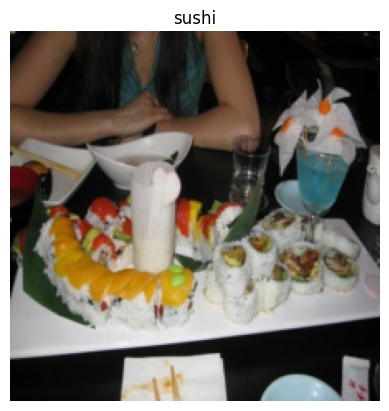

In [ ]:
# Plota uma imagem usando matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

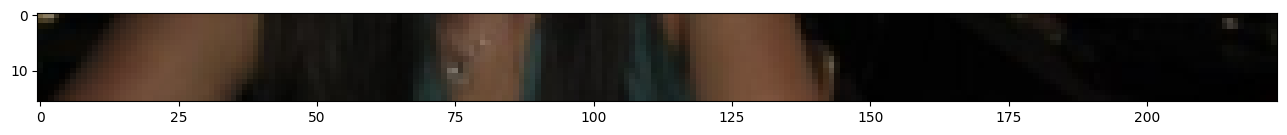

In [ ]:
# Muda a imagem para ser compatível com o matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


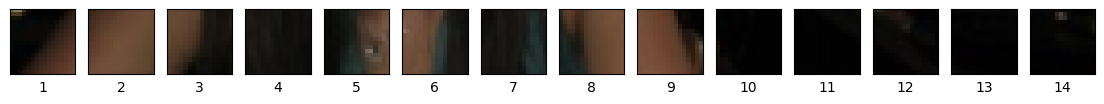

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Cria uma série de subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # 1 coluna para cada patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Intera entre o número de patches na primeira coluna
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # mantém index da altura constante, muda o index do comprimento
    axs[i].set_xlabel(i+1) # adiciona a legenda
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


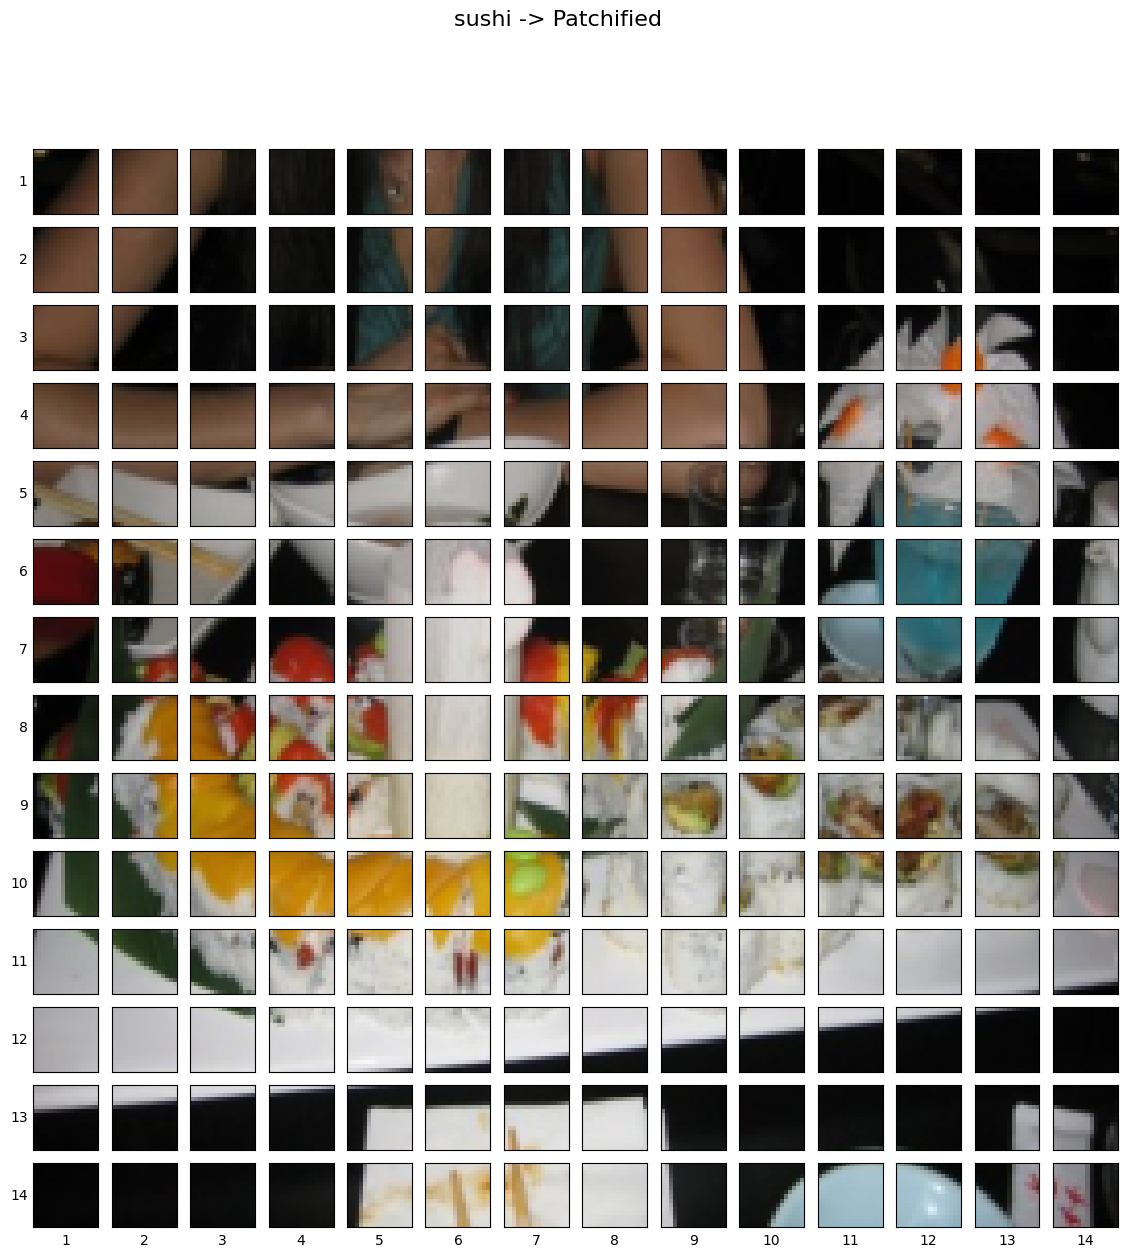

In [ ]:
# Configura os hyperparameters e mantém a certeza do img_size e patch_size são compatíveis
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Cria uma série de subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop entre altura e comprimento da imagem
for i, patch_height in enumerate(range(0, img_size, patch_size)): # itera entre altura
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # itera entre comprimento

        # Plota a imagem (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # itera entre altura
                                        patch_width:patch_width+patch_size, # itera entre comprimento
                                        :]) # todos os canais de cores

        # Adiciona legenda
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Adiciona um título
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [ ]:
patch_size=16

# Cria a camada conv2d com os hyperparameters do ViT paper
conv2d = nn.Conv2d(in_channels=3, # numero dos canais de cor
                   out_channels=768, # Table 1: Hidden size D
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

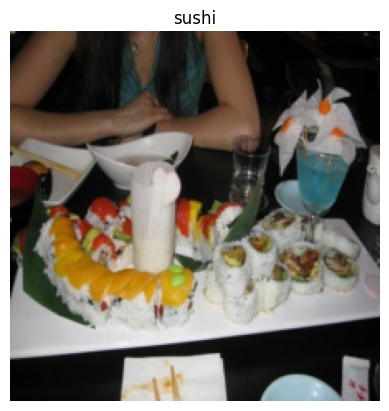

In [ ]:
# Visualiza uma única imagem
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Passa a imagem dentro da camada convolutional
image_out_of_conv = conv2d(image.unsqueeze(0)) # adiciona uma única camada (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


### Diminuir a dimensão

In [ ]:
# cria a camada Flatten
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


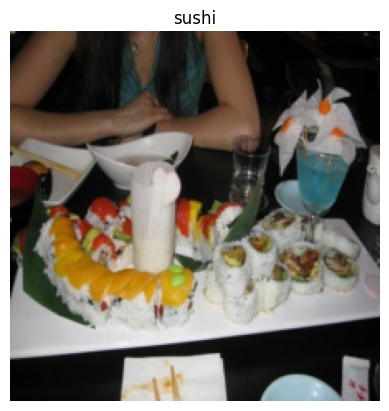

In [ ]:
# 1. Visualiza uma única imagem
plt.imshow(image.permute(1, 2, 0)) #
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Transforma a imagem em feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


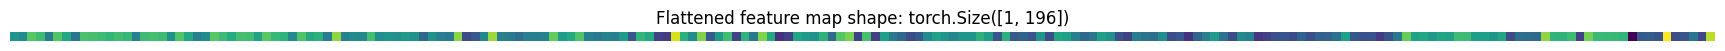

In [ ]:
# Obter uma única Flatten
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plota o Flatten para visualização
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

## Recriar o Transformer do paper

![vit_figure.png](https://github.com/google-research/vision_transformer/raw/main/vit_figure.png)

In [ ]:
# Para obter uma constância
def set_seeds(seed: int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)

In [ ]:
set_seeds()

# 1. Tamanho do patch
patch_size = 16

# 2.Obter dimensões das imagens
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Obter tensor da imagem e adiciona no batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Cria o layer patch embedding
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Passa a imagem entre o patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Cria o token da classe embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # tenha certeza que é aprendizável
print(f"Class token embedding shape: {class_token.shape}")

# 7. Class token embedding para patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Cria embedding de posição
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # tenha certeza que é aprendizável

# 9. Adiciona position embedding para patch embedding com class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Criando o multi-head self-attention block ("MSA block")

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Cria o multi-head self-attention block ("MSA block").
    """
    # 2. Inicializa a classe com os hyperparameters da Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D da Table 1 ViT-Base
                 num_heads:int=12, # Heads da Table 1 ViT-Base
                 attn_dropout:float=0):
        super().__init__()

        # 3. Cria a Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Cria a camada Multi-Head Attention (MSA)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    # 5. Cria o método forward() para passar os dados entre as camadas
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [ ]:
# Cria a instância do MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Passa o patch e position image embedding para o MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Criando a camada do normalized multilayer perceptron block ("MLP block").

In [ ]:
# 1. Cria a classe do nn.Module
class MLPBlock(nn.Module):
    """Cria a camada do normalized multilayer perceptron block ("MLP block")."""
    # 2. Inicializa a classe com os hyperparameters da Table 1 e Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D da Table 1
                 mlp_size:int=3072, # MLP size da Table 1
                 dropout:float=0.1): # Dropout da Table 3
        super().__init__()

        # 3. Cria a Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Cria a Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    # 5. Cria o método forward() para passar os dados entre as camadas
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Cria a instância do MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # da Table 1
                     mlp_size=3072, # da Table 1
                     dropout=0.1) # da Table 3

# Passa o MSABlock dentro do MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Criando um Transformer Encoder block.

In [ ]:
# 1. Cria a classe do nn.Module
class TransformerEncoderBlock(nn.Module):
    """Cria um Transformer Encoder block."""
    # 2. Inicializa a classe com os hyperparameters da Table 1 e Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D da Table 1
                 num_heads:int=12, # Heads da Table 1
                 mlp_size:int=3072, # MLP size da Table 1
                 mlp_dropout:float=0.1, # Quantidade de dropout para dense layers da Table 3
                 attn_dropout:float=0): # Quantidade de dropout para attention layers
        super().__init__()

        # 3. Cria MSA block (equação 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Cria MLP block (equação 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Cria o método forward()
    def forward(self, x):

        # 6. Cria conexão residual para MSA block (adiciona o input para o output)
        x =  self.msa_block(x) + x

        # 7. Cria conexão residual para MLP block (adiciona o input para o output)
        x = self.mlp_block(x) + x

        return x

### Criando a arquitetura do Vision Transformer com os hiperparâmetros do ViT-Base

In [ ]:
# 1. Cria a classe do nn.Module
class ViT(nn.Module):
    """Cria a arquitetura do Vision Transformer com os hiperparâmetros do ViT-Base."""
    # 2. Inicializa a classe com os hyperparameters da Table 1 e Table 3
    def __init__(self,
                 img_size:int=224, # Resolução de treino da Table 3
                 in_channels:int=3, # Número de canais na imagem de entrada
                 patch_size:int=16, # Tammanho do patch
                 num_transformer_layers:int=12, # Camadas da Table 1
                 embedding_dim:int=768, # Hidden size D da Table 1
                 mlp_size:int=3072, # MLP size da Table 1
                 num_heads:int=12, # Heads da Table 1
                 attn_dropout:float=0, # Dropout para attention projection
                 mlp_dropout:float=0.1, # Dropout para dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout para patch e position embeddings
                 num_classes:int=1000): # Padrão para ImageNet
        super().__init__()

        # 3. Faça o tamanho da imagem ser divisíveil pelo patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calcula o número de (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Cria learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Cria learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Ccria o valor da embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Cria a camada patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Cria os blocos do Transformer Encoder (podemos criar estacas dos blocos de Transformer Encoder usando nn.Sequential())
        # Nota: O "*" significa "todos"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Cria classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Cria o método forward()
    def forward(self, x):

        # 12. Obtém batch size
        batch_size = x.shape[0]

        # 13. Cria a classe token embedding e expande para corresponder ao tamanho do batch equação 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" siginifica para inferir a dimensão

        # 14. Cria patch embedding (equação 1)
        x = self.patch_embedding(x)

        # 15. Concatena class embedding e patch embedding (equação 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Adiciona position embedding no patch embedding (equação 1)
        x = self.position_embedding + x

        # 17. Roda embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Passa o patch, position e class embedding dentro das camadas do transformer (equações 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Coloca o index 0 index entre o classifier (equação 4)
        x = self.classifier(x[:, 0])

        return x

In [ ]:
set_seeds()

# Cria um tensor aleatório com o mesmo formato de uma única imagem
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Cria uma instância do ViT com o número de classes que estamos trabalhando (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Passar uma imagem aleatória ao tensor da nossa ViT
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## Treinamento

In [ ]:

t0 = time.time()
_ = next(iter(train_dataloader))
print("1 batch carregado em", time.time()-t0, "s")

1 batch carregado em 0.610506534576416 s


In [ ]:
# Configura o otimizador usando os hiperparâmetros vindos do paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR da Table 3 para ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # valores padrões mas também mencionados no paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # Do ViT paper section 4.1 (Training & Fine-tuning) e Tabela 3 para ViT-* ImageNet-1k

# Configura a função de perda para multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

# Treina o modelo e salva os resultados em um dicionário
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
